# Modelling of K-NN Classifier for Amazon Food Review

In [24]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import sqlite3 as sq
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import TimeSeriesSplit , train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss, confusion_matrix,classification_report,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from imblearn import over_sampling
from tabulate import tabulate as tab
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Establishing a connection with amazon review database in sqlite format.
connection = sq.connect("database.sqlite")

In [3]:
# Reading the database file using pandas read sql query in AmazonReviewData variable.
AmazonReview = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""" , connection)

In [14]:
AmazonReview.shape

(525814, 10)

In [4]:
print(AmazonReview.head(2))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  


* Replacing the score of the review with positive (score > 3) and negative (score < 3).

In [11]:
def Score(num):
    if num < 3:
        return 'negative'
    else:
        return 'positive'
    

In [12]:
score = []

for x in range (len(AmazonReview)):
    num = Score(AmazonReview['Score'][x])
    score.append(num)
AmazonReview['Score'] = score

In [13]:
AmazonReview.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Observations:

The dataset has 525814 reviews and 10 features.  
The amazon review dataset provides the following data:  
1) Id - review ID  
2) ProductID - unique Id for a given product  
3) UserID - Unique Id for the user  
4) ProfileName - Profile name of the user  
5) HelpfulnessNumerator - number of user who found the review heplful  
6) HelpfulnessDenominator - total number of users who found the review to be helpful or not.  
7) Score - product rating between 1 to 5 ( 3 been neutral, 1 & 2 been negative and 4 & 5 been positive)  
8) Time - timestamp of the review  
9) Summary - brief sumary of the review  
10) Text - text of the review  

Objective is to determine whether a given review is positive or negative using K-NN classifier.  
To do this, we replace the score column of amazon review as positive or negative by replacing all the values in score column below 3 as negative and above 3 as positive. All the reviews with score 3 are omitted, since they are neutral reviews (Neutral reviews donot help us in determining whether a given review is positive or negative).

In [15]:
# Removing all the duplicate data from the review.
AmazonReviewDataFiltered = AmazonReview.drop_duplicates(subset = {"UserId","Time","Text"}, keep = "first", inplace = False)
AmazonReviewDataFiltered.shape

(364133, 10)

# There were  161681 duplicate reviews.

In [16]:
AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator > AmazonReviewDataFiltered.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Since HelpfulnessNumerator indicates that the review was helpful for the user and HelpfulnessDenominator indicates the whether the review has helped or not the user, therefore it is clear that helpfulnessNumerator will always be less than HelpfulnessDenominator. In all the reviews where helpfulnessNumerator is greater than HelpfulnessDenominator indicates its a false entry and therefore should be neglected. There are two such reviews as shown above 

In [17]:
#Program to remove those reviews where helpfulnessNumerator is greater than helpfulnessDenominator.
AmazonReviewDataFiltered = AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator <= AmazonReviewDataFiltered.HelpfulnessDenominator]
AmazonReviewDataFiltered.shape

(364131, 10)

## Text Preprocessing

In [18]:
def HtmlTagREmover(sentence):
    """Function to remove all the HTML tags in a given sentence using Regular Expressions"""
    tagPattern = re.compile('<*.?>')
    textClean = re.sub(tagPattern,r'', sentence)
    return textClean

In [19]:
def PuncRemover(sentence):
    """Function to remove all the Punctuation marks in a given sentence using regular expressions"""
    punPattern = re.sub(r'[? | ! | \ | \' | " | # | . | , | : | ( | ) | / | ]', r'', sentence)
    return punPattern

In [20]:
stopWordRequired = {'not'}
snoBallStemmer = SnowballStemmer ('english')# initialising the snowball stemmer
stopWordsEnglish = set(stopwords.words('english', )) - stopWordRequired #set of all the stopwords in english except 'not'.

In [21]:
# Program to remove stopwords, punctuations, special characters and stemming each words. 
i = 0
positivewords = [] # list to store all the positive words in a review text.
negativewords = [] # list to store all the negative words in a review text.
filteredSentence = [] # list to store all the filtered review text.
for sentn in AmazonReviewDataFiltered['Text'].values:
    filteredSent = []
    sentn = HtmlTagREmover(sentn)
    for word in sentn.split():
        for cleanedWord in PuncRemover(word).split():
            if (cleanedWord.isalpha() & (len(cleanedWord) > 2)):
                if (cleanedWord.lower() not in stopWordsEnglish):
                    stemmerWord = snoBallStemmer.stem(cleanedWord.lower())
                    filteredSent.append(stemmerWord)
                    if (AmazonReviewDataFiltered['Score'].values)[i] == 'positive':
                        positivewords.append(stemmerWord)
                    else:
                        negativewords.append(stemmerWord)
                else:
                    continue
            else:
                continue
    i += 1
    string1 =" ".join(filteredSent)
    filteredSentence.append(string1)
            

In [22]:
AmazonReviewDataFiltered['Text'] = filteredSentence# Replacing the original text of amazon review datatset with the filtered one.
AmazonReviewDataFiltered['Text'].head()

0    bought sever vital can dog food product found ...
1    product arriv label jumbo salt peanutsth peanu...
2    confect around centuri light pillowi citrus ge...
3    look secret ingredi robitussin believ found go...
4    great taffi great price wide assort yummi taff...
Name: Text, dtype: object

In [24]:
AmazonReviewDataFiltered['Score'].value_counts()

positive    307026
negative     57105
Name: Score, dtype: int64

# Observation:
**There are 307026 positive reviews and 57105 negative reviews out of 364131 total reviews. Hence we have 84.3 % of positive reviews and 15.7% negative reviews  **

** It also tells us that the amazon review dataset has an imbalanced dataset.**

In [25]:
#Program to form a sentence using all the positive words from the review text.
positivesent = ''
for word in positivewords:
    positivesent += ' ' + word

In [26]:
#Program to form a sentence using all the negative words from the review text.
negativesent = ''
for word in negativewords:
    negativesent += ' ' + word

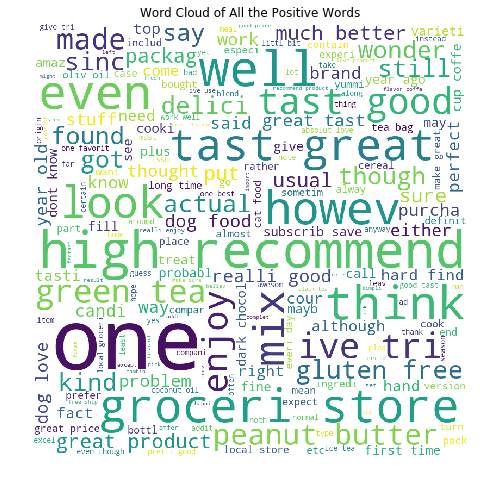

In [30]:
print('Sentence with all positive words in the reviews :\n')
print(positivesent[:25])
print('\n')
print('Sentence with all negative words in the reviews :\n')
print(negativesent[:25])

#Program to form a word cloud of all the positive in the review text.
wordcloud_positive_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(positivesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_positive_words)
plt.title("Word Cloud of All the Positive Words")
plt.axis('off')
plt.show()


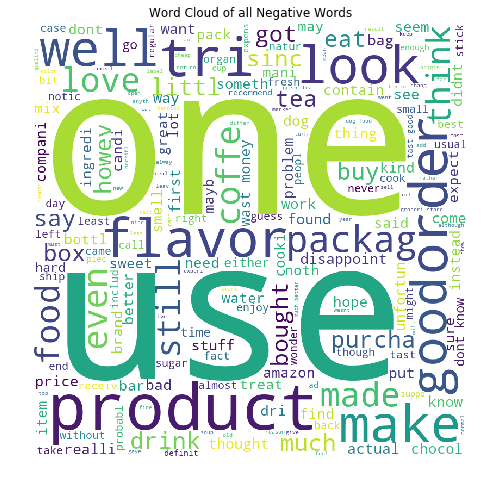

In [70]:
#Program to form a word cloud of all the positive in the review text.
wordcloud_negative_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(negativesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_negative_words)
plt.title("Word Cloud of all Negative Words")
plt.axis('off')
plt.show()

In [32]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'positive'].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'negative'].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
3AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 

In [53]:
# Extablishing connection and storing the filtered amazon data set in AmazonReviewDataSampled.sqlite database
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

In [25]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

In [26]:
#AmazonReviewDataSampled = AmazonReviewDataSampled.drop('level_0', axis = 1)
AmazonReviewDataSampled.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,positive,1234137600,Excellent taste and quality,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,positive,1285718400,Limited Variety,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,positive,1179100800,Victor Fly Bag is Great!,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,positive,1310169600,GOOD COFFEE,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,positive,1308528000,One of the best tools in my tool chest for dea...,tea tasti import knock back queasi start first...


In [27]:
# Program to split the positive and negative reviews of the amazon dataset.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 'positive']

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 'negative']
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [28]:
AmazonReviewDataSampledPositive.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44503,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
76271,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,one movi movi collect fill comedi action whate...
14486,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
49280,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,realli good idea final product outstand use de...


In [29]:
AmazonReviewDataSampledNegative.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
89700,89700,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,negative,992217600,CASPER IS THE GHOST WITH THE MOST,michael keaton bring distinguish characterist ...
93897,93897,230327,B00004RYGX,A3M5O6UHXO9IBU,Gary,2,34,negative,1052265600,Certificate: Puerile,embarrass comedi come like child attent defici...
94769,94769,225941,B000PKFZH8,A375QRG43POEW6,dndnd,23,25,negative,1069977600,Stay Away...,product ship great packag look good tast horri...
93593,93593,342462,B000084F3O,A3DWUM6SN3N3NR,"Author Brian Wallace (Mind Transmission, Inc.)",4,33,negative,1076457600,the most unnatural odor,realli hate fan van patten year feel must save...


In [30]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [31]:
AmazonReviewDataSampledTrain.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
1,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,one movi movi collect fill comedi action whate...
2,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
3,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,realli good idea final product outstand use de...
4,64330,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,sick scad nasti toothpick counter tint concept...


In [32]:
AmazonReviewDataSampledTest.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,37662,192950,B000OV08FC,A3DMVZ9D6XSS1E,Hannah,0,0,positive,1328572800,Good coffee,easi quick make heat water empti sachet lot le...
1,84246,107310,B005DFL4PM,AOTUPV596EAHL,Callie14,0,0,positive,1328572800,OMG... like Reeses,bought most put protein shake without calori l...
2,23050,420167,B005NVU5BK,A2J19U8H5SSFCJ,Linda Dalton,0,0,positive,1328572800,Excellent chocolate,never heard brand amazon offer special promot ...
3,27788,120546,B005K4Q37A,AYWXEYT90R54K,Jennifer Komarek,0,0,positive,1328572800,Love it!,not big coffe drinker drink coffe use lot crea...
4,38612,56323,B0039ZOZ86,A24EDLRX54TE36,"Gretchen Fehling ""tawonda""",1,1,positive,1328572800,great snack for dieters!@,great dieter calori per pack great throw lucnc...


In [13]:
AmazonReviewDataSampledTrain['Score'].value_counts()

positive    59010
negative    10990
Name: Score, dtype: int64

# Observation: The train dataset has 59k positive reviews and 10k negative reviews. Hence the train dataset is imbalanced. The total reviews in the train dataset is 70k.

In [14]:
AmazonReviewDataSampledTest['Score'].value_counts()

positive    25290
negative     4710
Name: Score, dtype: int64

# Observation: The test dataset has 25k positive reviews and 4.7k negative reviews. Total reviews in test dataset is 30k

# Converting Text to vectors using BOW, TFIDF, W2V and TFIDF- AVGW2V

# 1) Bag of Words

In [17]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])


In [18]:
bowTrain

<70000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 2195461 stored elements in Compressed Sparse Row format>

# Observation : BOW for training dataset is a sparse matrix with 42.8k dimensions.

In [19]:
#Program to store the bag of words vectors
file1 = open('bowTrain', 'wb')
pickle.dump(bowTrain, file1)

In [26]:
# loading the stored bag of words vector
fileBow = open('bowTrain', 'rb')
bowTrain = pickle.load(fileBow)

In [27]:

bowTrain

<70000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 2195461 stored elements in Compressed Sparse Row format>

In [25]:
# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTest['Text'])
bowTest

<30000x26577 sparse matrix of type '<class 'numpy.int64'>'
	with 947485 stored elements in Compressed Sparse Row format>

# Observation : BOW for test dataset is a sparse matrix with 26.5k dimensions.

In [26]:
#Program to store the bag of words vectors
file2 = open('bowTest', 'wb')
pickle.dump(bowTest, file2)

In [29]:
file3 = open('bowTest', 'rb')
bowTest = pickle.load(file3)
bowTest

<30000x26577 sparse matrix of type '<class 'numpy.int64'>'
	with 947485 stored elements in Compressed Sparse Row format>

#  2) TF - IDF

In [18]:
#Inilialzing and obtaining the TF-IDF of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'].values)

In [18]:
features = tfidfVec.get_feature_names()# to get the features of tfidf vector.

In [19]:
#Program to store the tf-idf vectors
feattfidf = open('featurestfidfsaved', 'wb')
pickle.dump(features, feattfidf)

tfidf = open('tfidfvecTrain', 'wb')
pickle.dump(tfidfvecTrain, tfidf)

In [8]:
file1 = open('featurestfidfsaved', 'rb')
features = pickle.load(file1)
file = open('tfidfvecTrain', 'rb')
tfidfvecTrain =pickle.load(file) 
tfidfvecTrain

<70000x994451 sparse matrix of type '<class 'numpy.float64'>'
	with 4738319 stored elements in Compressed Sparse Row format>

# Observation : TFIDF for test dataset is a sparse matrix with 99.4k dimensions.

In [6]:
#obtaining the TF-IDF of the Test Dataset.
tfidfVecTest = tfidfVec.fit_transform(AmazonReviewDataSampledTest['Text'].values)
tfidf = open('tfidfvecTest', 'wb')
pickle.dump(tfidfvecTest, tfidf)

In [7]:
file = open('tfidfvecTest', 'rb')
tfidfvecTest =pickle.load(file) 
tfidfvecTest

<30000x539836 sparse matrix of type '<class 'numpy.float64'>'
	with 2046945 stored elements in Compressed Sparse Row format>

# Observation : TFIDF for test dataset is a sparse matrix with 53.9k dimensions.

# W2V, Average W2V and TFIDF Weighted W2V

In [12]:
#Program to obtain list of sentences from the train dataset.
i = 0 
listofsent = []
for sent in AmazonReviewDataSampledTrain['Text']:
    listofsent.append(sent.split())

In [13]:
# Training W2V model using the training dataset.
w2v_model = Word2Vec(listofsent, size = 50, min_count = 5, workers = 4)

In [14]:
w2vecmodel = open('w2vmodel', 'wb')
pickle.dump(w2v_model, w2vecmodel)

In [9]:
#Program to obtain the w2v, avgw2v and tfidf-w2v for the training dataset.
word2vectorsTrain = []  # list to store the word2vec for training dataset
avgWord2VectorTrain = []  # list to store avg word2vec for training dataset
tfidfweightedAvgWord2VecTrain = []  # list to store tfidf avg word2vec for training dataset
row = 0
for sentence in AmazonReviewDataSampledTrain['Text'].values:  # obtaining the text of each review.
    #print(row)
    sentenceVector= np.zeros(50)  # initializing a vector of dimension 50 to store the word2vec for each word of a text of given review.
    tfword2Vec = np.zeros(50)  # initializing a vector of dimension 50 to store the tfidf of each word in a text of a given review
    count = 0
    weight = 0
    for word in sentence.split():  # obtain each word of a given text and obtianing the vector of each word.
        #print(word)
        if word in (w2v_model.wv.vocab):
            sentenceVector += w2v_model.wv[word] # obtaining the word2vec for each sentenc in a given review text.
            wordvec = w2v_model.wv[word]  # obtaining the word2vec for each word.
            tfidf1 = tfidfVectorsTrain[row, featuresTest.index(word)]  # obtaining the TFIDF vector of word.
            tfword2Vec += (wordvec * tfidf1)  # obtaining the tfidf for each sentence in a given review text.
            count += 1

            weight += tfidf1
        else:
            continue
    word2vectorsTrain.append(sentenceVector)  # word2vec for each review text.
    if count != 0:
        sentenceVector /= count
    avgWord2VectorTrain.append(sentenceVector)  # avg word2vec for each review text.
    if weight != 0:
        tfword2Vec /= weight
    tfidfweightedAvgWord2VecTrain.append(tfword2Vec)  # tfidf avg word2vec for each review text.
    row += 1

w2vTrain = open('word2vectorsTrain', 'wb')
pickle.dump(word2vectorsTrain, w2vTrain)

avw2vTrain = open('avgWord2VectorTrain','wb')
pickle.dump(avgWord2VectorTrain, avw2vTrain)

tfidfw2vTrain = open('tfidfweightedAvgWord2VecTrain', 'wb')
pickle.dump(tfidfweightedAvgWord2VecTrain, tfidfw2vTrain)


In [10]:
 #Program to obtain the w2v, avgw2v and tfidf-w2v for the training dataset.   
word2vectorsTest = []  # list to store the word2vec for test dataset
avgWord2VectorTest = []  # list to store avg word2vec for test dataset
tfidfweightedAvgWord2VecTest = []  # list to store tfidf avg word2vec for test dataset
row = 0
for sentence in AmazonReviewDataSampledTest['Text'].values:  # obtaining the text of each review.
    
    sentenceVector= np.zeros(50)  # initializing a vector of dimension 300 to store the word2vec for each word of a text of given review.
    tfword2Vec = np.zeros(50)  # initializing a vector of dimension 300 to store the tfidf of each word in a text of a given review
    count = 0
    weight = 0
    for word in sentence.split():  # obtain each word of a given text and obtianing the vector of each word.
        # print(word)
        if word in (w2v_model.wv.vocab):
            sentenceVector += w2v_model.wv[word] # obtaining the word2vec for each sentenc in a given review text.
            wordvec = w2v_model.wv[word]  # obtaining the word2vec for each word.
            tfidf1 = tfidfVectorsTest[row, featuresTest.index(word)]  # obtaining the TFIDF vector of word.
            tfword2Vec += (wordvec * tfidf1)  # obtaining the tfidf for each sentence in a given review text.
            count += 1

            weight += tfidf1
        else:
            continue
    word2vectorsTest.append(sentenceVector)  # word2vec for each review text.
    if count != 0:
        sentenceVector /= count
    avgWord2VectorTest.append(sentenceVector)  # avg word2vec for each review text.
    if weight != 0:
        tfword2Vec /= weight
    tfidfweightedAvgWord2VecTest.append(tfword2Vec)  # tfidf avg word2vec for each review text.
    row += 1

w2vTest = open('word2vectorsTest', 'wb')
pickle.dump(word2vectorsTest, w2vTest)

avw2vTest = open('avgWord2VectorTest','wb')
pickle.dump(avgWord2VectorTest, avw2vTest)

tfidfw2vTest = open('tfidfweightedAvgWord2VecTest', 'wb')
pickle.dump(tfidfweightedAvgWord2VecTest, tfidfw2vTest)
    

# K- NN Classifier for the Amazon Food Review Dataset.

** We observe that the Amazon food review datatset is an imbalance dataset, with positive reviews making around 85% of the total reviews. Hence its necessary to make the dataset balanced before giving it to the K-NN classifier.**  

** We have the train dataset which has 59010 positive and 10990 negative reviews, while the test dataset has 25290 positive reviews and 4710 negative review. ** 

** We will model the K-NN classifier with 10 fold cross validation using BRUTE FORCE and KD Tree algorithm, to select the best value of k.  **  

** Since the dataset is imbalanced, Log loss is used to evaluate the performance of the model. A perfect classifier would have a Log Loss of precisely zero. Less ideal classifiers have progressively larger values of Log Loss. **

** We will determine the best value of k in two different methods. First by converting the imbalance dataset to balance dataset by using SMOTE Technique and Second by Directly using the imbalance dataset.  **



# Obejective :  To determine whether a given Review is a positive review or not.

# Method 1:

# Using SMOTE Technique.

# 1) Brute Force Algorithm

# Bag Of Words

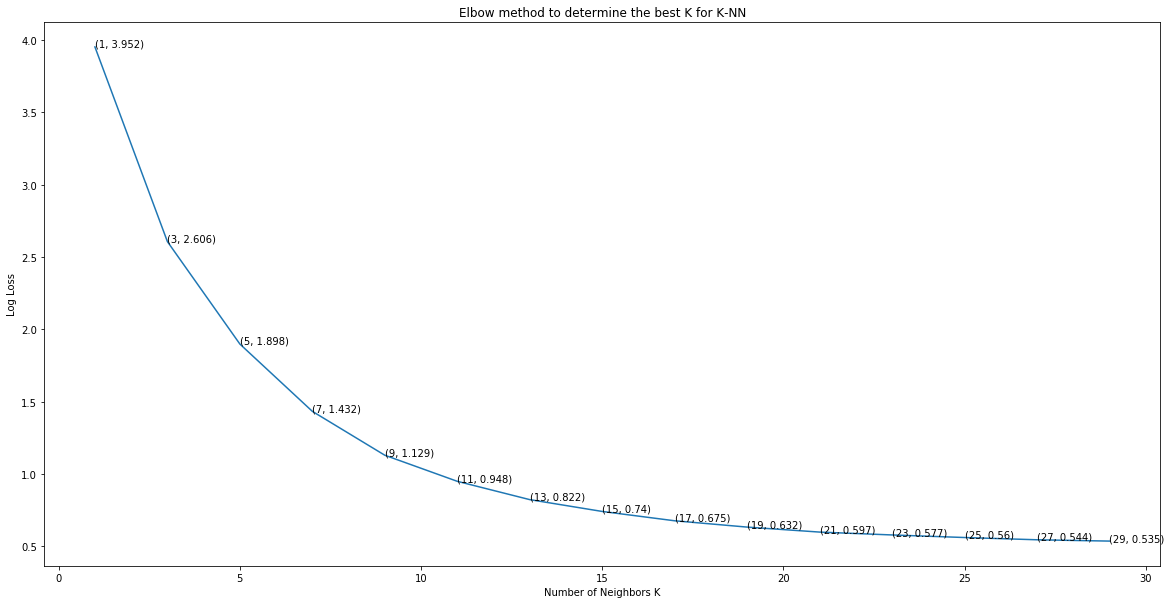

In [14]:
#Program to find the best K for K-NN classifier using the ELBOW METHOD
cv_scores = [] # variable to store cross validation scores
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
#Program to open the bag of words of train dataset
file1 = open('bowTrain', 'rb') 
bowTrain = pickle.load(file1)
bowTrain = TruncatedSVD(n_components= 50).fit_transform(bowTrain) # performing truncated SVD to reduce the dimensions to 50
bowTrain = StandardScaler().fit_transform(bowTrain)# performing standardization 
sm = over_sampling.SMOTE(ratio= 1.0) # initializing SMOTE technique 
x_tr_resam,y_tr_resam = sm.fit_sample(bowTrain, AmazonReviewDataSampledTrain['Score'])# resampling the train datatset so that positive reviews = negative reviews
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'brute') # initializing the K-NN classifier
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss') 
    cv_scores.append(scores.mean() * (-1))
    

# storing the cv scores
file1 = open('cv_scores_Smote_bowTrain', 'wb')
pickle.dump(cv_scores,file1)

# ploting cv scores v/s k
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 15, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [27]:
# Program to evaluate the accuracy of the K-NN classifier using the best value of K

file2 = open('bowTest', 'rb')
bowTest = pickle.load(file2)
bowTest = TruncatedSVD(n_components= 50).fit_transform(bowTest) # reducing the dimensions of test dataset using Truncated SVD
bowTest = StandardScaler().fit_transform(bowTest) # performing standardization of test dataset
sm = over_sampling.SMOTE(ratio= 1) # initializing the SMOTE technique
x_tr_resam, y_tr_resam = sm.fit_sample(bowTrain, AmazonReviewDataSampledTrain['Score'])# resampling the train dataset
knn_optimal_model = KNeighborsClassifier(n_neighbors= 15, weights = 'distance', n_jobs = 1, algorithm = 'brute')# initialzing the K-NN classifier using the best value of k.
knn_optimal_model.fit(x_tr_resam,y_tr_resam) # fitting the model
pred_prob = knn_optimal_model.predict_proba(bowTest) # predicitng the probability of the class label using the test dataset
pred = knn_optimal_model.predict(bowTest) # prediciting the class label using the test dataset.
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob) # calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred) # obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (15, Logloss))
print('\nThe confusion matrix for BOW using K-NN with k = 15 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')



The Log loss for the k - NN classifier for (k = 15 )is = 1.619257

The confusion matrix for BOW using K-NN with k = 15 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 3025  1685]
 [12466 12824]]




** 1) Accuracy of the model = (TN+TP)/total = (3025 + 12824) / 30000 = 52.83 % ** 

** 2) True Positive Rate (TPR) = TP/actual positive = 12824 / 25290  = 50.70%  ** 

** 3) True Negative Rate (TNR) = TN / actual negative = 3025 / 4710  = 64.22% **

# TFIDF

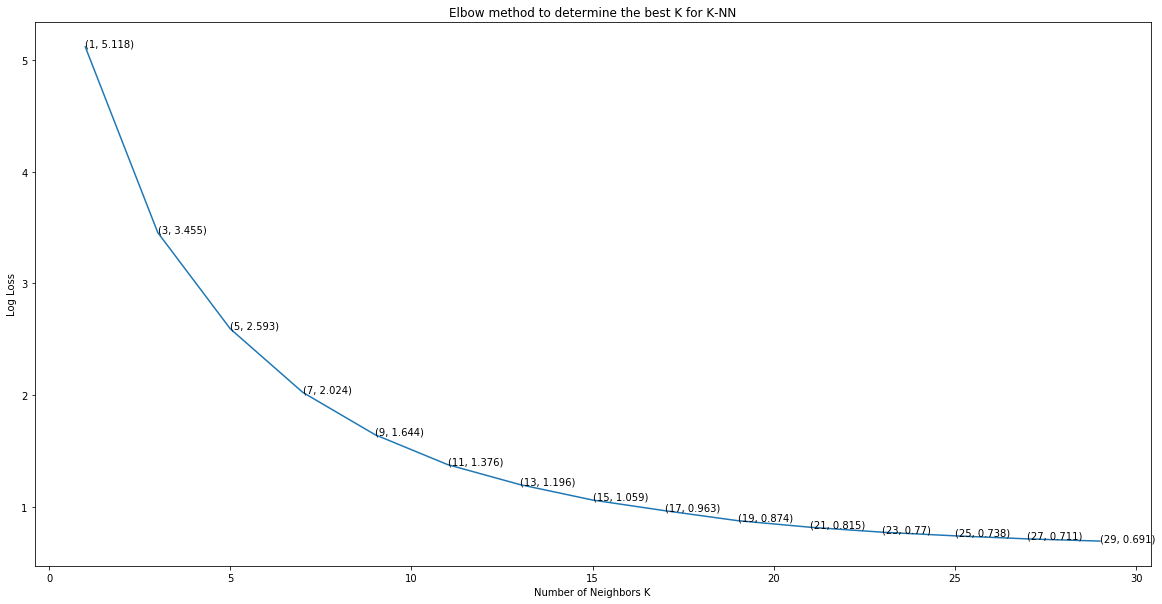

In [11]:
#Program to find the best K for K-NN classifier using the ELBOW METHOD
cv_scores = [] # variable to store cross validation scores
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('tfidfvecTrain', 'rb')
tfidfvecTrain = pickle.load(file1)
tfidfvecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTrain)# performing truncated SVD to reduce the dimensions to 50
tfidfvecTrain = StandardScaler().fit_transform(tfidfvecTrain)# performing standardization
sm = over_sampling.SMOTE(ratio= 1.0) # initializing SMOTE technique 
x_tr_resam,y_tr_resam = sm.fit_sample(tfidfvecTrain, AmazonReviewDataSampledTrain['Score'])# resampling the train datatset so that positive reviews = negative reviews
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'brute')# initializing the K-NN classifier
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))


file1 = open('cv_scores_Smote_tfidftrain', 'wb')
pickle.dump(cv_scores,file1)
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()




# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [30]:
# Program to evaluate the accuracy of the K-NN classifier using the best value of K


file2 = open('tfidfvecTest', 'rb')
tfidfvecTest = pickle.load(file2)
tfidfvecTest = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTest)# reducing the dimensions of test dataset using Truncated SVD
tfidfvecTest = StandardScaler().fit_transform(tfidfvecTest)# performing standardization of test dataset
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam, y_tr_resam = sm.fit_sample(tfidfvecTrain, AmazonReviewDataSampledTrain['Score'])# resampling the train dataset
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'brute')# initialzing the K-NN classifier using the best value of k.
knn_optimal_model.fit(x_tr_resam,y_tr_resam) # fitting the model
pred_prob = knn_optimal_model.predict_proba(tfidfvecTest)# predicitng the probability of the class label using the test dataset
pred = knn_optimal_model.predict(tfidfvecTest)# predicitng  the class label using the test dataset
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)# calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)# obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for tfidf using K-NN with k = 17 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')



The Log loss for the k - NN classifier for (k = 17 )is = 1.818573

The confusion matrix for tfidf using K-NN with k = 17 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 3383  1327]
 [15029 10261]]




** 1) Accuracy of the model = (TN + TP)/total = (3383 + 10261) / 30000 = 45.48 % ** 

** 2) True Positive Rate (TPR) = TP/actual positive = 102 / 25290  = 40.57 %  ** 

** 3) True Negative Rate (TNR) = TN / actual negative = 3383 / 4710  = 71.82% **

# Word 2 Vec

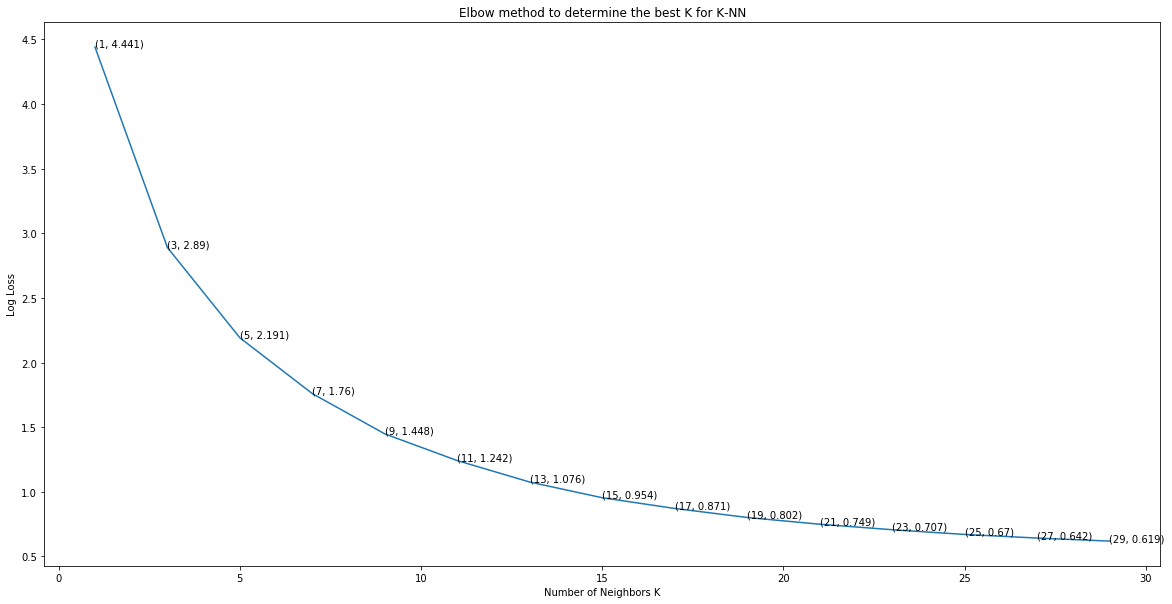

In [16]:
#Program to find the best K for K-NN classifier using the ELBOW METHOD
cv_scores = [] # variable to store cross validation scores
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('word2vectorsTrain', 'rb')
word2vectorsTrain = pickle.load(file1)
#word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
word2vectorsTrain = StandardScaler().fit_transform(word2vectorsTrain)# performing standardization on train dataset
sm = over_sampling.SMOTE(ratio= 1.0)# initializing SMOTE technique
x_tr_resam,y_tr_resam = sm.fit_sample(word2vectorsTrain, AmazonReviewDataSampledTrain['Score']) #resampling the train dataset 
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'brute')# initializing the K-NN classifier
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))


file1 = open('cv_scores_Smote_word2vectorsTrain', 'wb')
pickle.dump(cv_scores,file1)
#Program to plot c scores v/s K 
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()

# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [33]:
# Program to predict the accuracy of the K-NN classifier using the best value of k.
file2 = open('word2vectorsTest', 'rb')
word2vectorsTest = pickle.load(file2)
#word2vectorsTest = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTest)
word2vectorsTest = StandardScaler().fit_transform(word2vectorsTest) # performing standardization of the test dataset
sm = over_sampling.SMOTE(ratio= 1.0)# initializing the SMOTE technique
x_tr_resam, y_tr_resam = sm.fit_sample(word2vectorsTrain, AmazonReviewDataSampledTrain['Score'])# resmapling the train dataset
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'brute')# initializing the K-NN classifier
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(word2vectorsTest) # prediciting the probability of the class label of the test dataset
pred = knn_optimal_model.predict(word2vectorsTest) # prediciting the class label of the test dataset
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)# calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred) # obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for word2vector using K-NN with k = 17 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 17 )is = 1.087067

The confusion matrix for word2vector using K-NN with k = 17 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 4710     0]
 [25290     0]]




 1) Accuracy of the model = (TN + TP)/total = (4710 + 0) / 30000 = 15.7 %

2) True Positive Rate (TPR) = TP/actual positive = 0 / 25290 = 0 %

3) True Negative Rate (TNR) = TN / actual negative = 4710 / 4710 = 100%


# TFIDF Weighted Average W2V

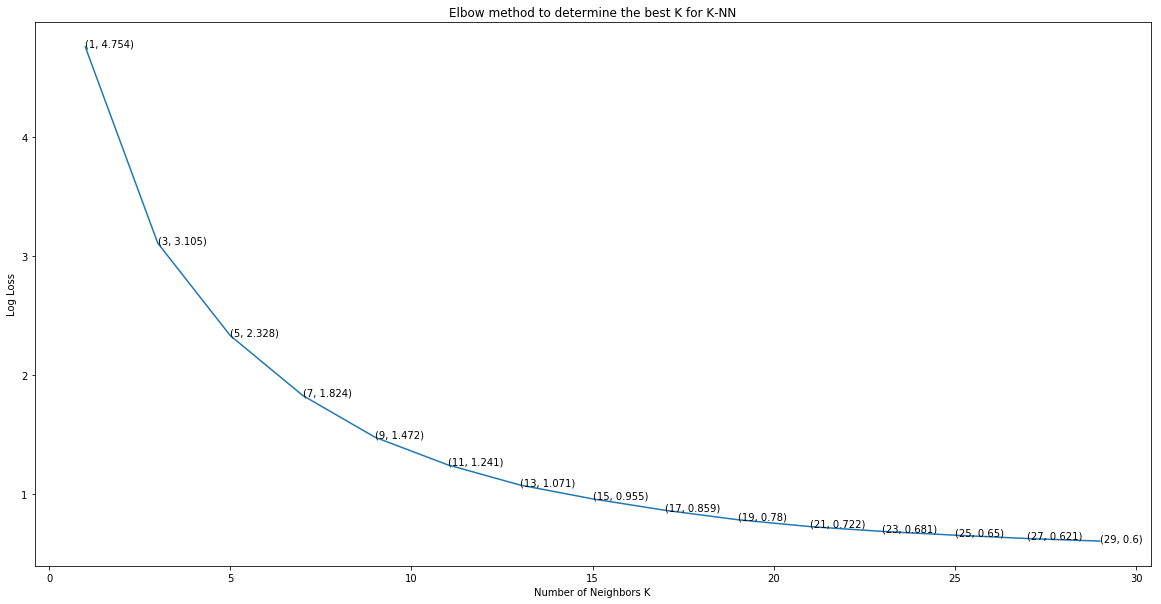

In [18]:
#Program to find the best K for K-NN classifier using the ELBOW METHOD 
cv_scores = []# variable to store the cv scores
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('tfidfweightedAvgWord2VecTrain', 'rb')
tfidfweightedAvgWord2VecTrain = pickle.load(file1)
#word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
tfidfweightedAvgWord2VecTrain = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTrain) #performing standardization of the train dataset
sm = over_sampling.SMOTE(ratio= 1.0)# initialization of the SMOTE technique
x_tr_resam,y_tr_resam = sm.fit_sample(tfidfweightedAvgWord2VecTrain, AmazonReviewDataSampledTrain['Score']) # resampling the train dataset
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'brute')# initializing the K-NN classifier
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))


file1 = open('cv_scores_Smote_tfidfweightedAvgWord2VecTrain', 'wb')
pickle.dump(cv_scores,file1)
# plot cv scores v/s k
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()

# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [36]:
# Program to predict the accuracy of the K-NN classifier using the best k.

file2 = open('tfidfweightedAvgWord2VecTest', 'rb')
tfidfweightedAvgWord2VecTest = pickle.load(file2)
#word2vectorsTest = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTest)
tfidfweightedAvgWord2VecTest = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTest)# performing standardization of the test dataset
sm = over_sampling.SMOTE(ratio= 1.0)# initializing the SMOTE technique
x_tr_resam, y_tr_resam = sm.fit_sample(tfidfweightedAvgWord2VecTrain, AmazonReviewDataSampledTrain['Score']) # initializing the K-NN classifier using the best value of k
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'brute')
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(tfidfweightedAvgWord2VecTest)# predicting the probability of the class label of the test datatset
pred = knn_optimal_model.predict(tfidfweightedAvgWord2VecTest)# predicting the class label of the test dataset
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob) # calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred) # obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for TFID WEIGHTED AVERAGE W2V using K-NN with k = 17 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 17 )is = 1.507928

The confusion matrix for TFID WEIGHTED AVERAGE W2V using K-NN with k = 17 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 4035   675]
 [11458 13832]]




** 1) Accuracy of the model = (TN + TP)/total = (4035 + 13832) / 30000 = 59.55% **

** 2) True Positive Rate (TPR) = TP/actual positive = 13832/ 25290 = 46.10 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 4035 / 4710 = 85.66 %  **


 # 2) KD Tree Algorithm
 
 # Bag of Words

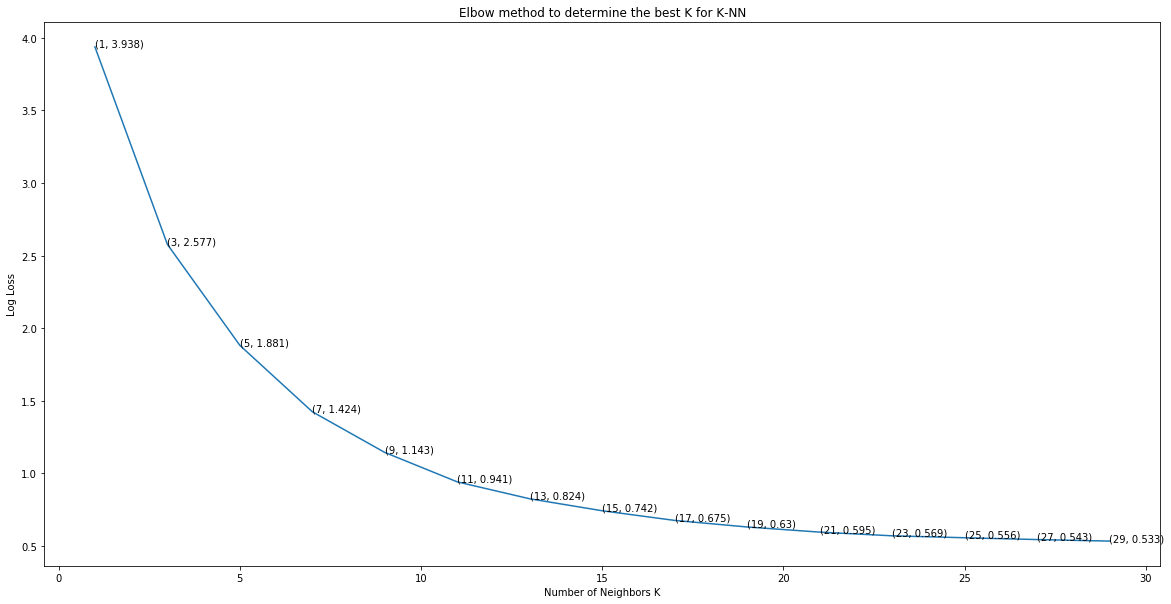

In [14]:
# Program to determine the best value of k using elbow method
cv_scores = []# variable to store the cv scores
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('bowTrain', 'rb')
bowTrain = pickle.load(file1)
bowTrain = TruncatedSVD(n_components= 50).fit_transform(bowTrain)# reducing the dimensions of train dataset using truncated SVD
bowTrain = StandardScaler().fit_transform(bowTrain)# performing standardization of the train datatset
sm = over_sampling.SMOTE(ratio= 1.0) # initializing the SMOTE technique
x_tr_resam,y_tr_resam = sm.fit_sample(bowTrain, AmazonReviewDataSampledTrain['Score']) # resampling the train dataset
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'kd_tree')# initializing the K-NN classifier
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))

file1 = open('cv_scores_Smote_kdtree_bowTrain', 'wb')
pickle.dump(cv_scores,file1)
#plot cv scores v/s k
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 15, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [38]:
#Program to predict the accuracy of the k_NN classifier using the best value of K

file2 = open('bowTest', 'rb')
bowTest = pickle.load(file2)
bowTest = TruncatedSVD(n_components= 50).fit_transform(bowTest) # reducing the dimensions of test dataset
bowTest = StandardScaler().fit_transform(bowTest)# standardization of test dataset
sm = over_sampling.SMOTE(ratio= 1)
x_tr_resam, y_tr_resam = sm.fit_sample(bowTrain, AmazonReviewDataSampledTrain['Score'])
knn_optimal_model = KNeighborsClassifier(n_neighbors= 15, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(bowTest)# predicting the probability of the class label of test datatset
pred = knn_optimal_model.predict(bowTest)# predicting the class label of test datatset
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)# calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)# obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (15, Logloss))
print('\nThe confusion matrix for BOW using K-NN with k = 15 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')



The Log loss for the k - NN classifier for (k = 15 )is = 1.723081

The confusion matrix for BOW using K-NN with k = 15 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 3122  1588]
 [12652 12638]]




** 1) Accuracy of the model = (TN + TP)/total = (3122 + 12638) / 30000 = 52.53 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 12638/ 25290 = 42.12 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 3122 / 4710 = 66.28 %  **


# TFIDF

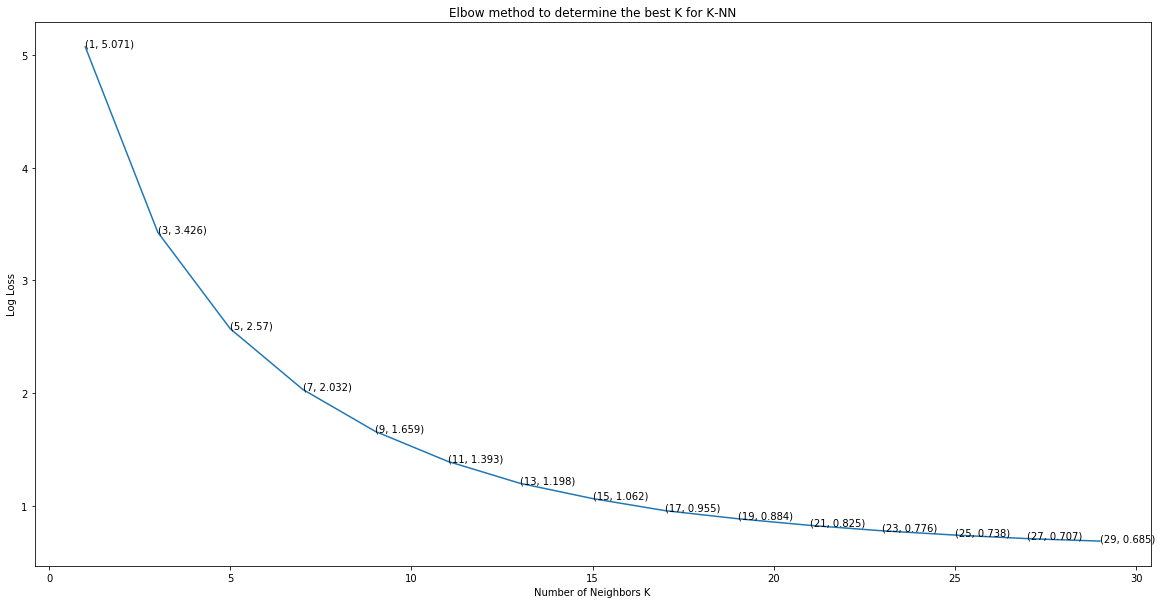

In [15]:
# Program to determine the best k for k-NN classifier using elbow method
cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('tfidfvecTrain', 'rb')
tfidfvecTrain = pickle.load(file1)
tfidfvecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTrain) # dimension reduction of train dataset
tfidfvecTrain = StandardScaler().fit_transform(tfidfvecTrain)# standardization of train dataset
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam,y_tr_resam = sm.fit_sample(tfidfvecTrain, AmazonReviewDataSampledTrain['Score'])
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'kd_tree')
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))

file1 = open('cv_scores_Smote_kdtree_tfidftrain', 'wb')
#plot of cv scores v/s k
pickle.dump(cv_scores,file1)
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [40]:
# Program to predict the accuracy of the K-NN classifier using the best value of k
file2 = open('tfidfvecTest', 'rb')
tfidfvecTest = pickle.load(file2)
tfidfvecTest = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTest)
tfidfvecTest = StandardScaler().fit_transform(tfidfvecTest) # standardization of test dataset
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam, y_tr_resam = sm.fit_sample(tfidfvecTrain, AmazonReviewDataSampledTrain['Score'])
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(tfidfvecTest)
pred = knn_optimal_model.predict(tfidfvecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob) # predicting the probability of class label of the test class
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred) # predicting the class label of test class
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for tfidf using K-NN with k = 17 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')



The Log loss for the k - NN classifier for (k = 17 )is = 1.764550

The confusion matrix for tfidf using K-NN with k = 17 and kd tree algorithm is as follows : 

Confusion Matrix :


[[ 3499  1211]
 [14596 10694]]




** 1) Accuracy of the model = (TN + TP)/total = (3499 + 10694) / 30000 = 47.31 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 10694/ 25290 = 42.28 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 3499 / 4710 = 74.28 %  **

# Word2Vec

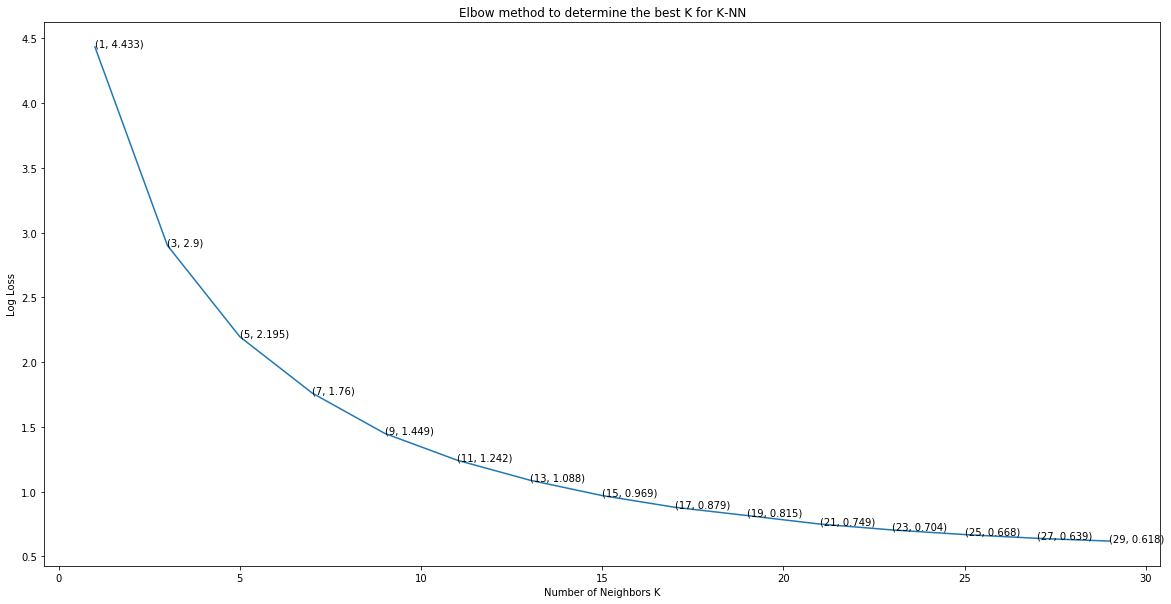

In [17]:
##Program to find the best K for K-NN classifier using the ELBOW METHOD
cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('word2vectorsTrain', 'rb')
word2vectorsTrain = pickle.load(file1)
#word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
word2vectorsTrain = StandardScaler().fit_transform(word2vectorsTrain)#Standardization of train datatset
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam,y_tr_resam = sm.fit_sample(word2vectorsTrain, AmazonReviewDataSampledTrain['Score']) #resampling the train dataset
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'kd_tree')
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))

file1 = open('cv_scores_Smote_kdtree_word2vectorsTrain', 'wb')
pickle.dump(cv_scores,file1)
#plot cv scores v/s k
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()

# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [59]:
#Program to predict the accuracy of K-NN classifier using the best value of k
file2 = open('word2vectorsTest', 'rb')
word2vectorsTest = pickle.load(file2)
#word2vectorsTest = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTest)
word2vectorsTest = StandardScaler().fit_transform(word2vectorsTest)
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam, y_tr_resam = sm.fit_sample(word2vectorsTrain, AmazonReviewDataSampledTrain['Score'])
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(word2vectorsTest)# predicting the probability of the class label of the test dataset
pred = knn_optimal_model.predict(word2vectorsTest)# predicting the class label of the test dataset
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)# calculating the log loss
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)# obtaining the confusion matrix
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for word2vector using K-NN with k = 17 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 17 )is = 0.940394

The confusion matrix for word2vector using K-NN with k = 17 and kd tree algorithm is as follows : 

Confusion Matrix :


[[ 4710     0]
 [25290     0]]




** 1) Accuracy of the model = (TN + TP)/total = (4710 + 0) / 30000 = 15.70 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 0/ 25290 = 0 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 4710 / 4710 = 100 %  **

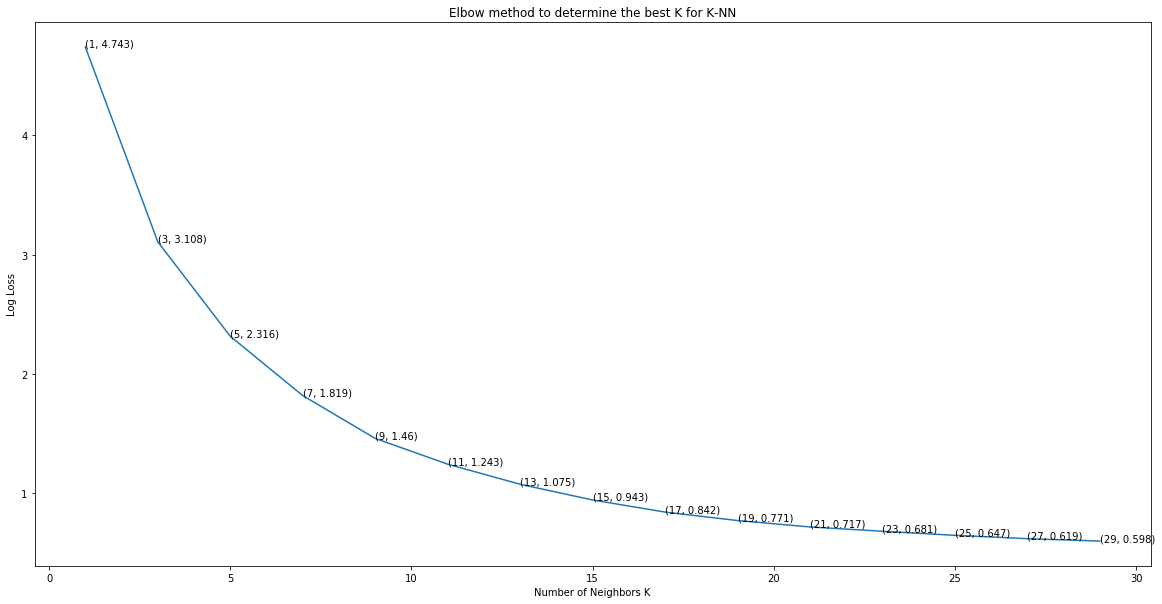

In [19]:
# Program the determine the best k for k-NN classifier using elbow method
cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
file1 = open('tfidfweightedAvgWord2VecTrain', 'rb')
tfidfweightedAvgWord2VecTrain = pickle.load(file1)
#word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
tfidfweightedAvgWord2VecTrain = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTrain)# standardization of the train dataset
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam,y_tr_resam = sm.fit_sample(tfidfweightedAvgWord2VecTrain, AmazonReviewDataSampledTrain['Score'])# resampling the train dataset
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 2, algorithm= 'kd_tree')
    scores = cross_val_score(knn, x_tr_resam,y_tr_resam,n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))
    #print("k = %r , loss = %r" %(k , scores.mean() * (-1)))


file1 = open('cv_scores_Smote_kdtree_tfidfweightedAvgWord2VecTrain', 'wb')
pickle.dump(cv_scores,file1)
#plot cv scores v/s k
plt.figure(figsize= (20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()

# Obseravtion: Using the elbow technique, we observe that k = 17, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [41]:
#Program to determine the accuracy of the k-NN classifier using the best k.
file2 = open('tfidfweightedAvgWord2VecTest', 'rb')
tfidfweightedAvgWord2VecTest = pickle.load(file2)
#word2vectorsTest = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTest)
tfidfweightedAvgWord2VecTest = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTest)
sm = over_sampling.SMOTE(ratio= 1.0)
x_tr_resam, y_tr_resam = sm.fit_sample(tfidfweightedAvgWord2VecTrain, AmazonReviewDataSampledTrain['Score'])
knn_optimal_model = KNeighborsClassifier(n_neighbors= 17, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(x_tr_resam,y_tr_resam)
pred_prob = knn_optimal_model.predict_proba(tfidfweightedAvgWord2VecTest)
pred = knn_optimal_model.predict(tfidfweightedAvgWord2VecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (17, Logloss))
print('\nThe confusion matrix for TFID WEIGHTED AVERAGE W2V using K-NN with k = 17 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 17 )is = 1.500102

The confusion matrix for TFID WEIGHTED AVERAGE W2V using K-NN with k = 17 and kd tree algorithm is as follows : 

Confusion Matrix :


[[ 4015   695]
 [11586 13704]]




** 1) Accuracy of the model = (TN + TP)/total = (4015 + 13704) / 30000 = 59.06 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 13704/ 25290 = 54.18 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 4015 / 4710 = 85.24 %  **

# Method 2 : Determining the best K using the imbalance dataset directly

# 1) Brute Force Algorithm

# Bag of Words

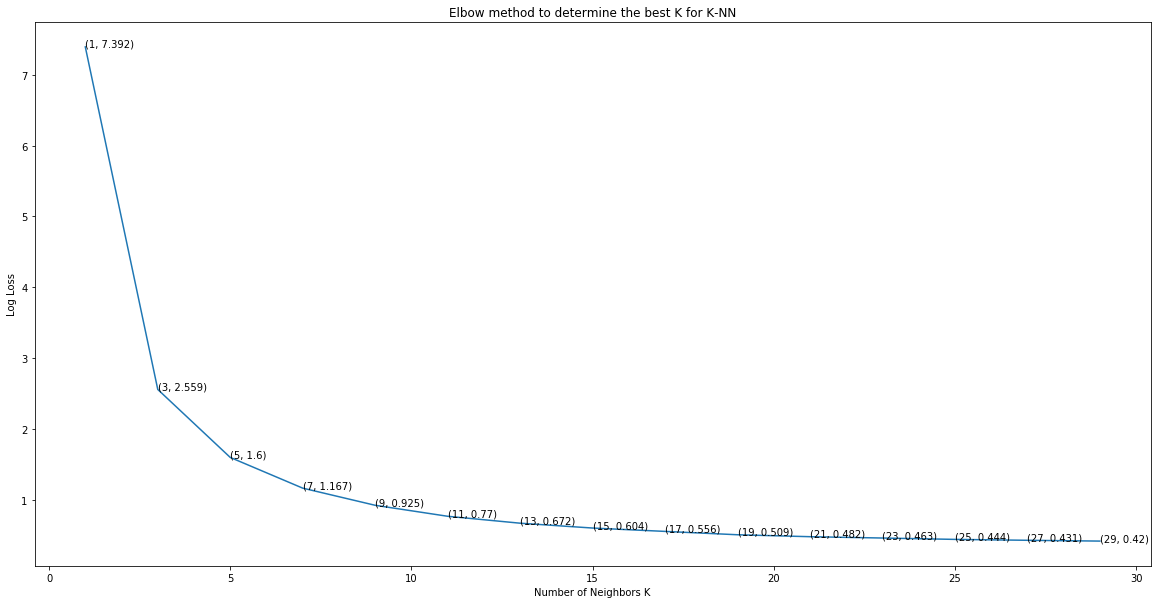

In [16]:
#Program to determine the best K for K-NN classifier using elbow method.
file1 = open('bowTrain', 'rb')
bowTrain = pickle.load(file1)
bowTrain = TruncatedSVD(n_components= 50).fit_transform(bowTrain)
bowTrain = StandardScaler().fit_transform(bowTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'brute')
    scores = cross_val_score(knn, bowTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot cv scores v/s k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 13, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [42]:
#program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 13, weights = 'distance', n_jobs = 1, algorithm = 'brute')
knn_optimal_model.fit(bowTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(bowTest)
pred = knn_optimal_model.predict(bowTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (13, Logloss))
print('\nThe confusion matrix for BOW using K-NN with k = 13 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 13 )is = 1.011944

The confusion matrix for BOW using K-NN with k = 13 and brute force algorithm is as follows : 

Confusion Matrix :


[[  542  4168]
 [  885 24405]]




** 1) Accuracy of the model = (TN + TP)/total = (542 + 24405) / 30000 = 83.15 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24405/ 25290 = 96.50 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 542 / 4710 = 11.50 %  **

# TFIDF

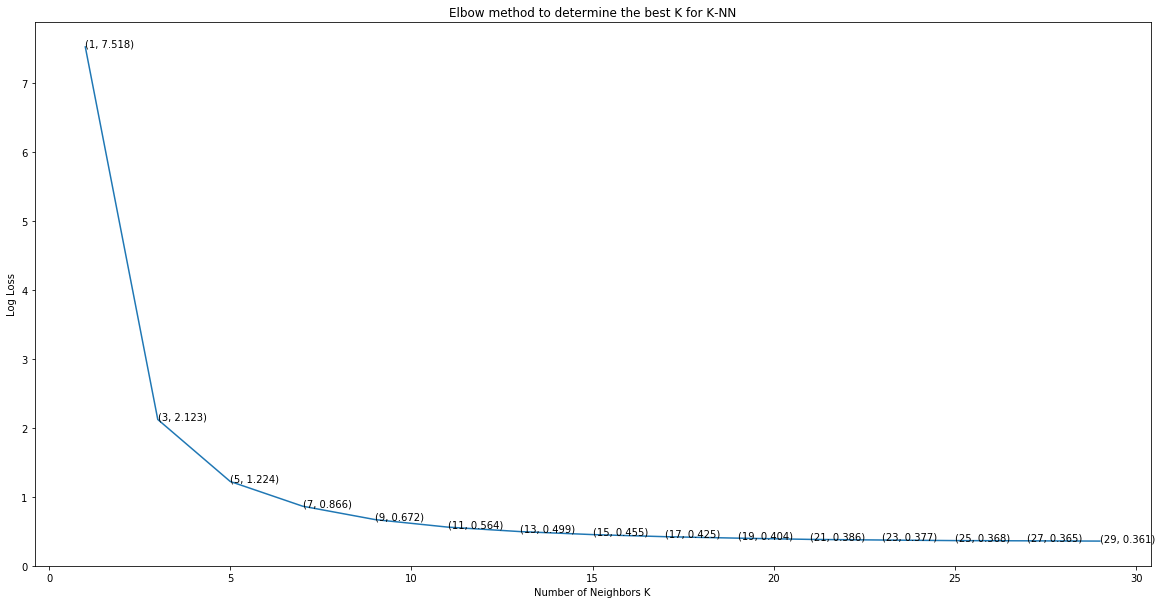

In [56]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('tfidfvecTrain', 'rb')
tfidfvecTrain = pickle.load(file1)
tfidfvecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTrain)
tfidfvecTrain = StandardScaler().fit_transform(tfidfvecTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'brute')
    scores = cross_val_score(knn, tfidfvecTrain,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot cv scores vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()

# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [57]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'brute')
knn_optimal_model.fit(tfidfvecTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(tfidfvecTest)
pred = knn_optimal_model.predict(tfidfvecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for TFIDF using K-NN with k = 11 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 1.076140

The confusion matrix for TFIDF using K-NN with k = 11 and brute force algorithm is as follows : 

Confusion Matrix :


[[  591  4119]
 [ 1259 24031]]




** 1) Accuracy of the model = (TN + TP)/total = (591 + 24031) / 30000 = 82.07 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24031/ 25290 = 95.02 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 591 / 4710 = 12.54 %  **

# Word2Vec

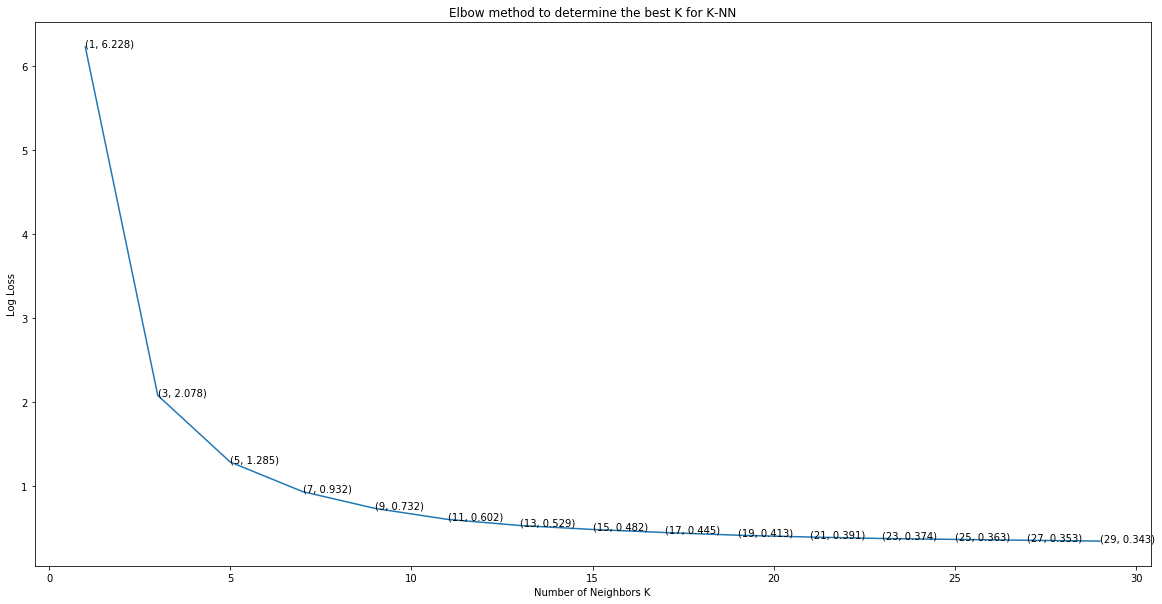

In [18]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('word2vectorsTrain', 'rb')
word2vectorsTrain = pickle.load(file1)
word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
word2vectorsTrain = StandardScaler().fit_transform(word2vectorsTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'brute')
    scores = cross_val_score(knn, word2vectorsTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot cv scores vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation using SMOTE techinque.

In [60]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'brute')
knn_optimal_model.fit(word2vectorsTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(word2vectorsTest)
pred = knn_optimal_model.predict(word2vectorsTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for word2vector using K-NN with k = 11 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 5.422588

The confusion matrix for word2vector using K-NN with k = 11 and brute force algorithm is as follows : 

Confusion Matrix :


[[    0  4710]
 [    0 25290]]




** 1) Accuracy of the model = (TN + TP)/total = (0 + 25290) / 30000 = 84.30 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 25290/ 25290 = 100 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 0 / 4710 = 0 %  **

# TFIDF - W2V

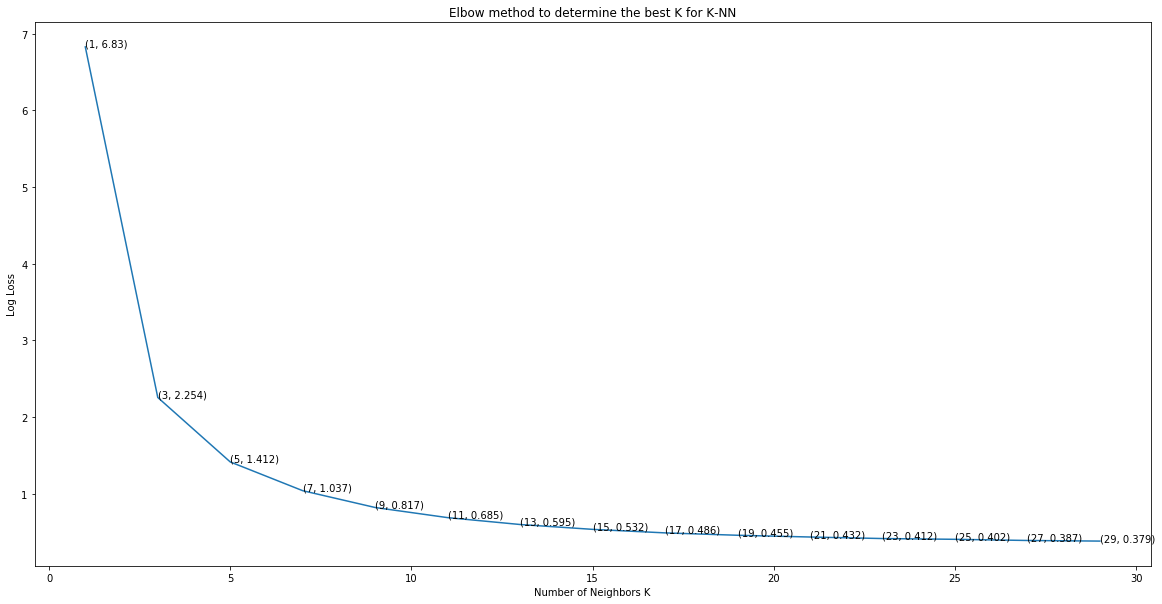

In [62]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('tfidfweightedAvgWord2VecTrain', 'rb')
tfidfweightedAvgWord2VecTrain = pickle.load(file1)
tfidfweightedAvgWord2VecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfweightedAvgWord2VecTrain)
tfidfweightedAvgWord2VecTrain = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'brute')
    scores = cross_val_score(knn, tfidfweightedAvgWord2VecTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot misclassification error vs k
plt.figure(figsize=(20,10))
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with brute force implemenation.

In [48]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'brute')
knn_optimal_model.fit(tfidfweightedAvgWord2VecTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(tfidfweightedAvgWord2VecTest)
pred = knn_optimal_model.predict(tfidfweightedAvgWord2VecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for TDIFD WEIGHTED AVERAGE W2V using K-NN with k = 11 and brute force algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 0.705360

The confusion matrix for TDIFD WEIGHTED AVERAGE W2V using K-NN with k = 11 and brute force algorithm is as follows : 

Confusion Matrix :


[[ 1222  3488]
 [  662 24628]]




** 1) Accuracy of the model = (TN + TP)/total = (1222 + 24628) / 30000 = 86.16 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24628/ 25290 = 97.38 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 1222 / 4710 = 25.94 %  **

# 2) KD Tree Algorithm

# Bag of Words

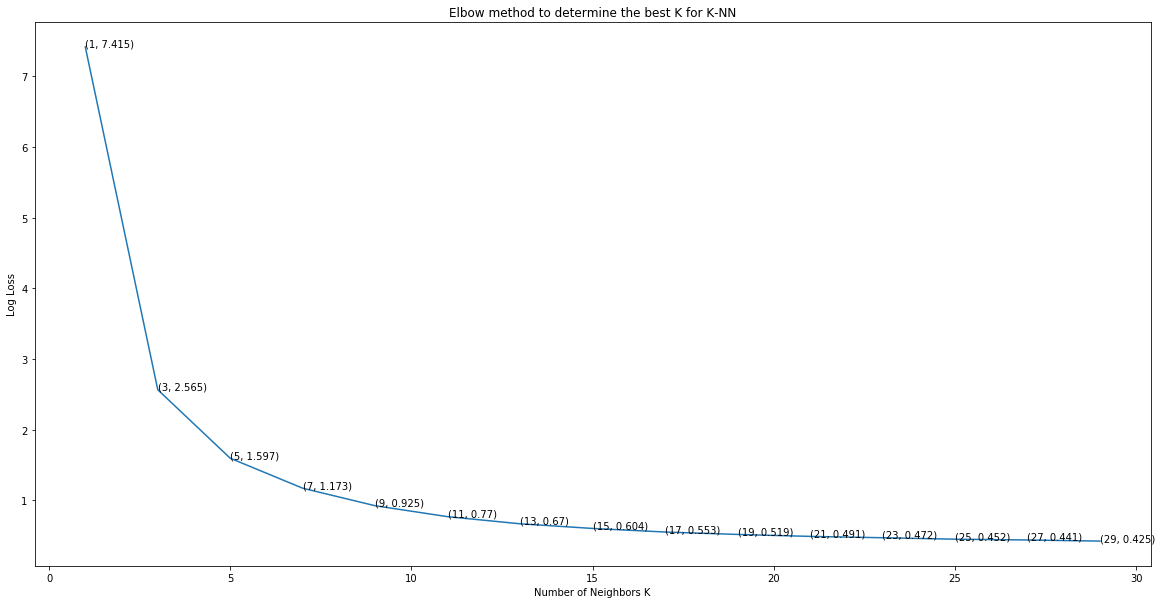

In [21]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('bowTrain', 'rb')
bowTrain = pickle.load(file1)
bowTrain = TruncatedSVD(n_components= 50).fit_transform(bowTrain)
bowTrain = StandardScaler().fit_transform(bowTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'kd_tree')
    scores = cross_val_score(knn, bowTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot misclassification error vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 13, is the best estimate of the hyperparameter for K -NN Classifier with kd tree implemenation.

In [49]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 13, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(bowTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(bowTest)
pred = knn_optimal_model.predict(bowTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (13, Logloss))
print('\nThe confusion matrix for BOW using K-NN with k = 13 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 13 )is = 1.011944

The confusion matrix for BOW using K-NN with k = 13 and kd tree algorithm is as follows : 

Confusion Matrix :


[[  542  4168]
 [  885 24405]]




** 1) Accuracy of the model = (TN + TP)/total = (542 + 24405) / 30000 = 83.15 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24405/ 25290 = 96.50 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 542 / 4710 = 11.50 %  **

# TFIDF

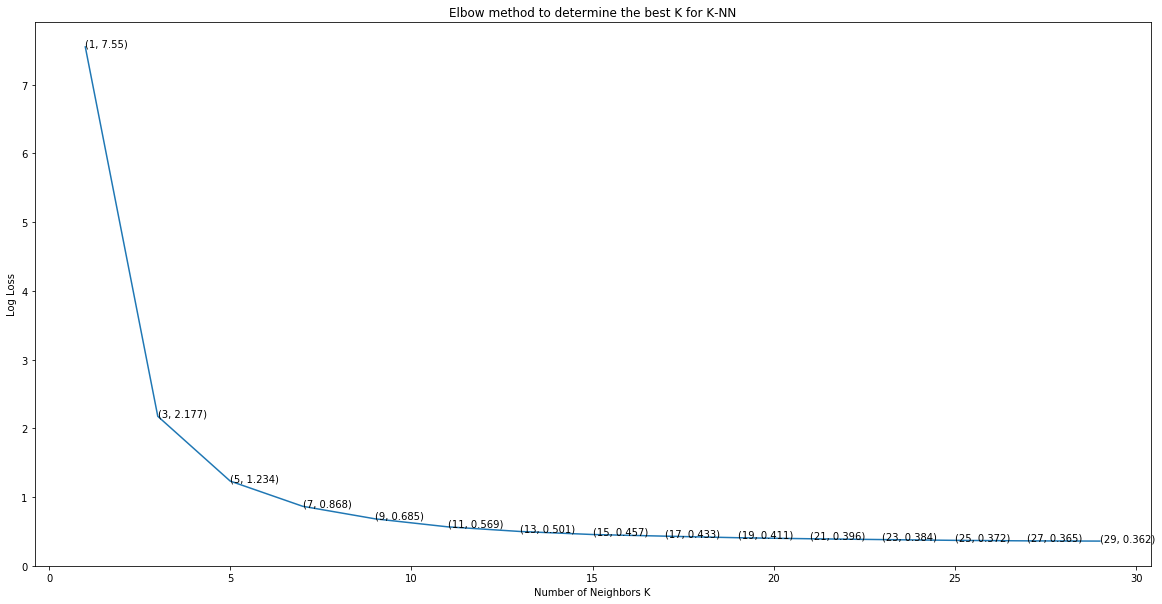

In [20]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('tfidfvecTrain', 'rb')
tfidfvecTrain = pickle.load(file1)
tfidfvecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfvecTrain)
tfidfvecTrain = StandardScaler().fit_transform(tfidfvecTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'kd_tree')
    scores = cross_val_score(knn, tfidfvecTrain,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot misclassification error vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with kd tree implemenation.

In [58]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(tfidfvecTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(tfidfvecTest)
pred = knn_optimal_model.predict(tfidfvecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for TFIDF using K-NN with k = 11 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 1.076140

The confusion matrix for TFIDF using K-NN with k = 11 and kd tree algorithm is as follows : 

Confusion Matrix :


[[  591  4119]
 [ 1259 24031]]




** 1) Accuracy of the model = (TN + TP)/total = (591 + 24031) / 30000 = 82.07 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24031/ 25290 = 80.10 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 591 / 4710 = 12.54 %  **

# Word2Vec

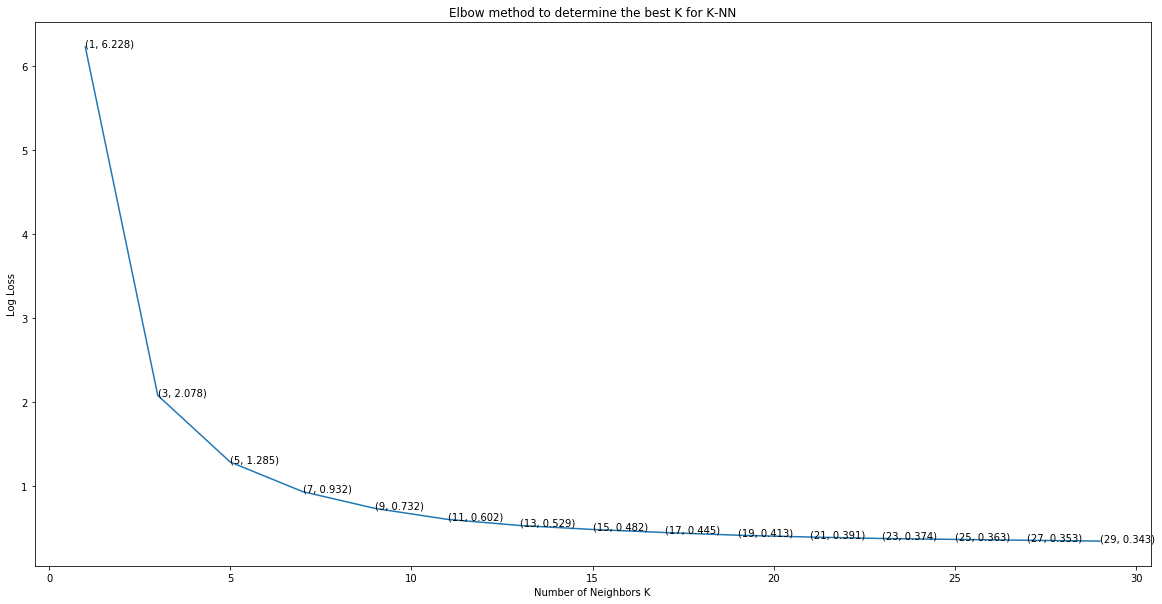

In [22]:
# Program to determine the best k for K-NN classifier using elbow method.
file1 = open('word2vectorsTrain', 'rb')
word2vectorsTrain = pickle.load(file1)
word2vectorsTrain = TruncatedSVD(n_components= 50).fit_transform(word2vectorsTrain)
word2vectorsTrain = StandardScaler().fit_transform(word2vectorsTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'kd_tree')
    scores = cross_val_score(knn, word2vectorsTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot misclassification error vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with kd tree implemenation.

In [51]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(word2vectorsTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(word2vectorsTest)
pred = knn_optimal_model.predict(word2vectorsTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for word2vector using K-NN with k = 11 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 5.422588

The confusion matrix for word2vector using K-NN with k = 11 and kd tree algorithm is as follows : 

Confusion Matrix :


[[    0  4710]
 [    0 25290]]




** 1) Accuracy of the model = (TN + TP)/total = (0 + 25290) / 30000 = 84.30 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 25290/ 25290 = 100 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 0 / 4710 = 0 %  **

# TFIDF -W2V

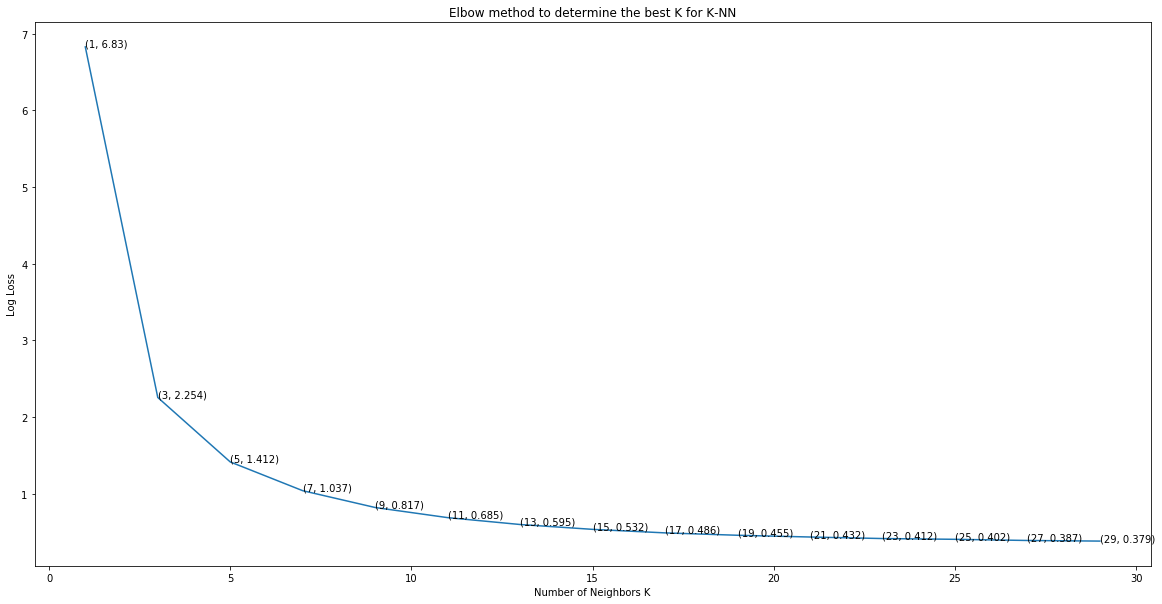

In [23]:
# Program to best k for K-NN classifier using elbow method.
file1 = open('tfidfweightedAvgWord2VecTrain', 'rb')
tfidfweightedAvgWord2VecTrain = pickle.load(file1)
tfidfweightedAvgWord2VecTrain = TruncatedSVD(n_components= 50).fit_transform(tfidfweightedAvgWord2VecTrain)
tfidfweightedAvgWord2VecTrain = StandardScaler().fit_transform(tfidfweightedAvgWord2VecTrain)

cv_scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights= 'distance', n_jobs= 4, algorithm= 'kd_tree')
    scores = cross_val_score(knn, tfidfweightedAvgWord2VecTrain ,AmazonReviewDataSampledTrain['Score'],n_jobs = 4, cv=10, scoring='neg_log_loss')
    cv_scores.append(scores.mean() * (-1))


# plot misclassification error vs k
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title("Elbow method to determine the best K for K-NN")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Log Loss')
plt.show()


# Obseravtion: Using the elbow technique, we observe that k = 11, is the best estimate of the hyperparameter for K -NN Classifier with kd tree implemenation.

In [52]:
# Program to predict the accuracy of the K-NN classifier using the best k.
knn_optimal_model = KNeighborsClassifier(n_neighbors= 11, weights = 'distance', n_jobs = 1, algorithm = 'kd_tree')
knn_optimal_model.fit(tfidfweightedAvgWord2VecTrain,AmazonReviewDataSampledTrain['Score'])
pred_prob = knn_optimal_model.predict_proba(tfidfweightedAvgWord2VecTest)
pred = knn_optimal_model.predict(tfidfweightedAvgWord2VecTest)
# evaluate accuracy
Logloss = log_loss(AmazonReviewDataSampledTest['Score'], pred_prob)
confusionMatrix = confusion_matrix(AmazonReviewDataSampledTest['Score'], pred)
print('\nThe Log loss for the k - NN classifier for (k = %d )is = %f' % (11, Logloss))
print('\nThe confusion matrix for TDIFD WEIGHTED AVERAGE W2V using K-NN with k = 11 and kd tree algorithm is as follows : ')
print('\nConfusion Matrix :')
print('\n')
print(confusionMatrix)
print('\n')


The Log loss for the k - NN classifier for (k = 11 )is = 0.705360

The confusion matrix for TDIFD WEIGHTED AVERAGE W2V using K-NN with k = 11 and kd tree algorithm is as follows : 

Confusion Matrix :


[[ 1222  3488]
 [  662 24628]]




** 1) Accuracy of the model = (TN + TP)/total = (1222 + 24628) / 30000 = 86.16 % **

** 2) True Positive Rate (TPR) = TP/actual positive = 24628/ 25290 = 97.38 % **

** 3) True Negative Rate (TNR) = TN / actual negative = 1222 / 4710 = 25.94 %  **

In [37]:
print('Table 1: Table showing the vectorizer, corresponding values of k and accuracy of the model trained using Balanced Dataset\n ')
table = [['BOW','BRUTE FORCE', 15,1.619,52.83],['TFIDF','BRUTE FORCE', 17,1.818,45.48],['W2V','BRUTE FORCE',17,1.087,15.7],['TFIDFW2V','BRUTE FORCE',17,1.507,59.55],['BOW','KD TREE', 15,1.72,52.53],['TFIDF','KD TREE', 17,1.76,47.31],['W2V','KD TREE',17,0.94,15.70],['TFIDFW2V','KD TREE',17,1.5,59.06]]
headers = ['Vectorizer ', 'Algorithm', 'Optimal or Best K', 'Log Loss', 'Accuracy in %']
print (tab(table, headers, tablefmt="grid",numalign = 'center'))


Table 1: Table showing the vectorizer, corresponding values of k and accuracy of the model trained using Balanced Dataset
 
+---------------+-------------+---------------------+------------+-----------------+
| Vectorizer    | Algorithm   |  Optimal or Best K  |  Log Loss  |  Accuracy in %  |
+===============+=============+=====================+============+=================+
| BOW           | BRUTE FORCE |         15          |   1.619    |      52.83      |
+---------------+-------------+---------------------+------------+-----------------+
| TFIDF         | BRUTE FORCE |         17          |   1.818    |      45.48      |
+---------------+-------------+---------------------+------------+-----------------+
| W2V           | BRUTE FORCE |         17          |   1.087    |      15.7       |
+---------------+-------------+---------------------+------------+-----------------+
| TFIDFW2V      | BRUTE FORCE |         17          |   1.507    |      59.55      |
+---------------+---------

In [36]:
print('Table 2: Table showing the vectorizer, corresponding values of k and accuracy of the model trained using imbalanced Dataset\n')
table = [['BOW','BRUTE FORCE', 13,1.011,83.15],['TFIDF','BRUTE FORCE', 11,1.076,82.07],['W2V','BRUTE FORCE',11,5.44,84.30],['TFIDFW2V','BRUTE FORCE',11,0.70,86.16],['BOW','KD TREE', 13,1.011,83.15],['TFIDF','KD TREE', 11,1.076,82.07],['W2V','KD TREE',11,5.42,84.30],['TFIDFW2V','KD TREE',11,0.705,86.16]]
headers = ['Vectorizer ', 'Algorithm', 'Optimal or Best K', 'Log Loss', 'Accuracy in %']
print (tab(table, headers, tablefmt="grid",numalign = 'center'))

Table 2: Table showing the vectorizer, corresponding values of k and accuracy of the model trained using imbalanced Dataset

+---------------+-------------+---------------------+------------+-----------------+
| Vectorizer    | Algorithm   |  Optimal or Best K  |  Log Loss  |  Accuracy in %  |
+===============+=============+=====================+============+=================+
| BOW           | BRUTE FORCE |         13          |   1.011    |      83.15      |
+---------------+-------------+---------------------+------------+-----------------+
| TFIDF         | BRUTE FORCE |         11          |   1.076    |      82.07      |
+---------------+-------------+---------------------+------------+-----------------+
| W2V           | BRUTE FORCE |         11          |    5.44    |      84.3       |
+---------------+-------------+---------------------+------------+-----------------+
| TFIDFW2V      | BRUTE FORCE |         11          |    0.7     |      86.16      |
+---------------+--------

# Conclusion:

** We observe that the log loss for a given vectorizer for balanced dataset is large as compared to imbalanced dataset, but if we look at the TRP and TNR , model trained with balanced dataset performs far better as compared to imbalanced dataset. **
** The accuracy of the model trained using imbalance dataset is better as compared to model trained with balance dataset, the reason for this is k-NN classifier uses majority vote to predict the class label of the test dataset. Since positive reviews are more its accuracy increases but if we observe at TPR and TNR, TNR is very small and TPR is very high. This indicates that the model trained using imbalance dataset predicts a query review as positive most of the time. **

** The accuracy of the model trained using balance dataset is less as compared to model trained using imbalance dataset, but if we look at the TPR and TNR of the model trained using balance dataset, both are almost the same. This indicates that the model is not baised towards the positive class which we observed for the model trained using imbalance dataset. ** 

** We also observe that, if TFIDFW2V is used as a vectorizer, the performance of the model is better whether the model is trained using balance or imbalance dataset. **

** The performance of the K - NN classifier can be improved further if a better technique is used to balance the dataset or by using different ratio and classifier is SMOTE technique. **

# END